# Анализ данных осень 2021
# Практический анализ данных и ML соревнования

Возьмём задачу из VK Cup 2020 года. Нужно:

- разобраться в данных, похожих на логи рекламных компаний соцсети
- придумать алгоритм оценки охвата аудитории
- посмотреть насколько точно предсказывается размер аудитории

**Будет много графиков**

#### Данные

Описание файлов и колонок:

users.csv:

- `user_id` – уникальный идентификатор пользователя
- `sex` – указанный пользователем пол в анкете
- `age` – указанный пользователем в анкете возраст пользователя. 0 – не указан.
- `city_id` - указанный пользователем в анкете город проживания. 0 – не указан.

history.csv:

- `hour` – в какой час пользователь видел объявление
- `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка.
- `publisher` - площадка, на который пользователь видел рекламу
- `user_id` - уникальный идентификатор пользователя

ads.csv:

- `ad_id` - id объявления для сопоставления с целевой переменной
- `cpm` - для какой цены объявления нужно сделать прогноз
- `hour_start` - предположительное время запуска рекламного объявления
- `hour_end` - предположительное время остановки рекламного объявления. По итогу прогноз делается для рекламного объявление, которое будет запущено в период времени [hour_start, hour_end]
- `publishers` - на каких площадках объявление может быть показано
- `audience_size` - размер аудитории объявления, количество идентификаторов в поле user_ids
- `user_ids` – аудитория объявления – список пользователей, кому рекламодатель хочет показать объявление.

target.csv:

- `ad_id` - id объявления для сопоставления с целевой переменной
- `at_least_one` - доля пользователей, которая увидит объявление хотя бы один раз


### Разберёмся в данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18, 3]

plt.style.use('dark_background')

%matplotlib inline

#### О пользователях

In [2]:
users = pd.read_csv('data/raw/users.csv')
print(f'dataset shape: {users.shape}')
users.head(7)

dataset shape: (27769, 4)


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
5,5,2,22,5
6,6,1,21,6


In [3]:
users = users[(users.age > 0) & (users.age <= 70) & (users.sex != 0)]

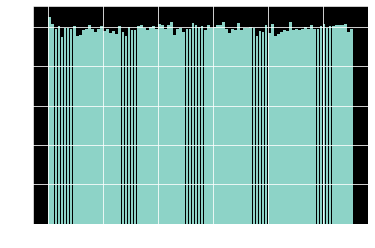

In [4]:
# Пользователи с какими id есть в данных?

users.user_id.hist(bins=100, rwidth=0.9);

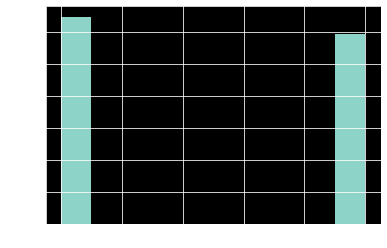

In [5]:
# Пол пользователей

users.sex.hist();

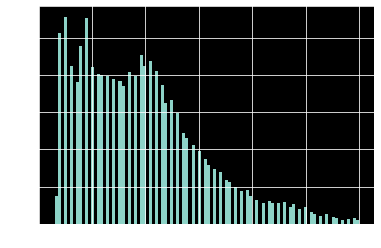

In [6]:
# Возраст основной аудитории
users.age.hist(bins=100);

Количество городов: 2352


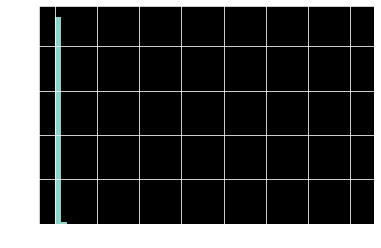

In [7]:
# Города пользователей

print(f'Количество городов: {len(users.city_id.unique())}')
# Сколько пользователей в каждом городе
vc = users.value_counts('city_id')
vc.hist(bins=50);

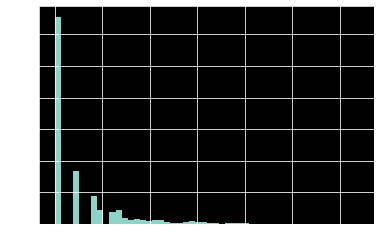

In [8]:
# Логарифмированное количество жителей городов
log2_vc = np.log2(vc)
log2_vc.hist(bins=50);

##### Менее тривиальные графики

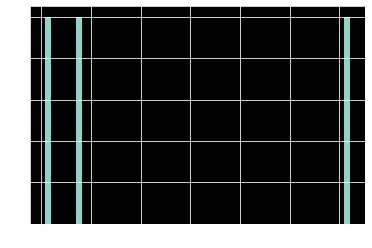

In [9]:
# Города с населением более 1к
vc[vc > 1000].hist(bins=50);

In [10]:
# Исследуем жителей больших городов
vc[vc > 1000]

city_id
0    7207
3    1783
7    1078
dtype: int64

In [11]:
cities_users = users[users.city_id.isin([0, 3, 7])]
cities_users.shape

(10068, 4)

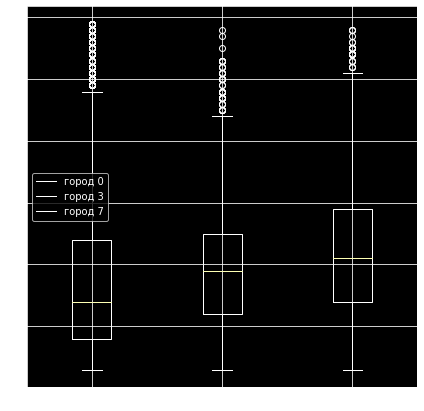

In [12]:
# Их возраст по городам

city_ages = cities_users[(cities_users.age > 0) & (cities_users.age < 70)].groupby('city_id').age.apply(list)

plt.figure(figsize=(7, 7))
plt.boxplot(city_ages)
plt.grid(True)
plt.legend([f'город {city_id}' for city_id in city_ages.index])
plt.show();

#### О рекламных компаниях

In [13]:
history = pd.read_csv('data/raw/history.csv')
print(history.shape)
history.head(7)

(1147857, 4)


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
5,5,70.00,2,16334
6,10,73.22,1,25931


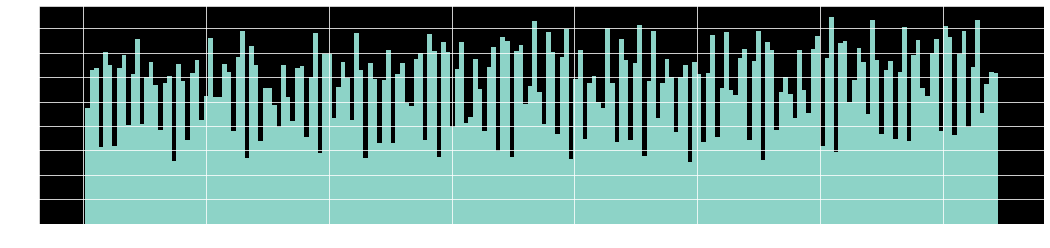

In [14]:
history.hour.hist(bins=200, figsize=(18, 4));

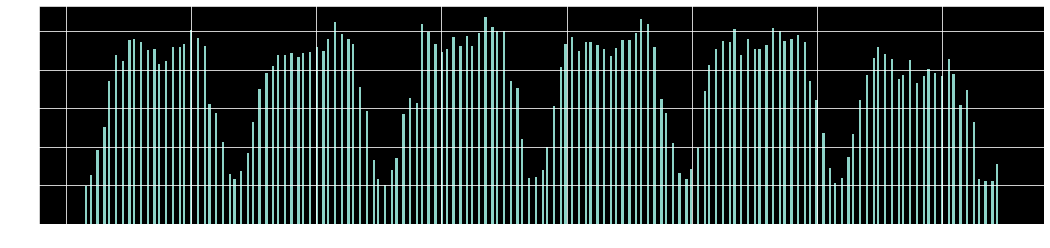

In [15]:
# Подробнее
history[history.hour < 150].hour.hist(bins=400, figsize=(18, 4));

Выглядит как дневные колебания, значит либо
- датасет нормализован по часовому поясу
- Москва и Санкт-Петербург очень сильно "перетягивают" на себя

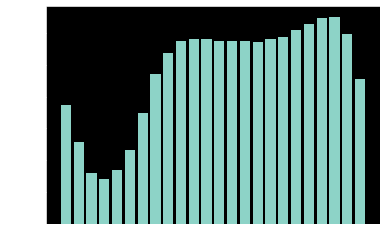

[21, 20, 19, 18, 22, 17, 16, 10, 11, 9, 13, 14, 12, 15]
9 22
День покрыт полностью


In [16]:
historyByHour = []
for i in range(24):
    historyByHour.append(len(history[history.hour % 24 == i]))
plt.bar(list(range(24)), historyByHour)
plt.show()
bestHours = \
    list ( map ( lambda x: x[0]
               , sorted ( zip(range(24), historyByHour)
                        , key=lambda x: -x[1]
                        ) [:14]
               )
         )
print(bestHours)
bestHours = sorted(bestHours)
print(bestHours[0], bestHours[-1])
if bestHours[-1] - bestHours[0] + 1 == len(bestHours):
    print('День покрыт полностью')

Можно заметить, что вечером активность больше чем утром (график не симметричен относительно середины периода min-min)

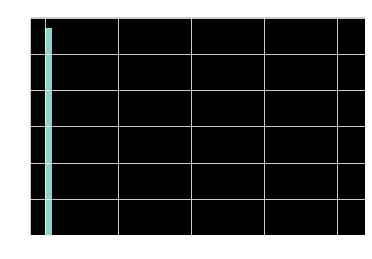

In [17]:
# Цены объявлений
history.cpm.hist(bins=50);

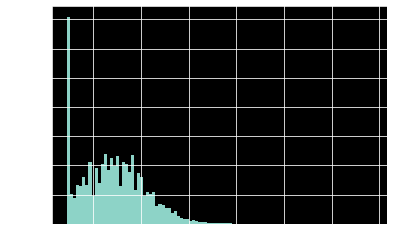

In [18]:
# Логарифмированные
cpms = history.cpm.apply(np.log2)
cpms.hist(bins=100);

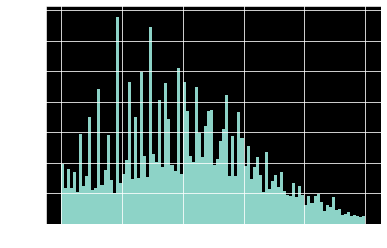

In [19]:
# Подробнее 
cpms[(cpms > 5) & (cpms < 10)].hist(bins=100);

publishers count: 21


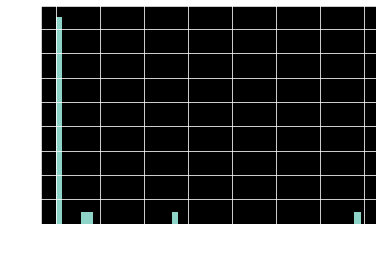

In [20]:
# Что за платформы для рекламы? Сколько их?

pubs = history.publisher.unique()
print('publishers count:', len(pubs))
vc = history.publisher.value_counts()
vc.hist(bins=50)
plt.xlabel('Количество объявлений')
plt.ylabel('Количество таких платформ');

[1, 2, 3, 7]


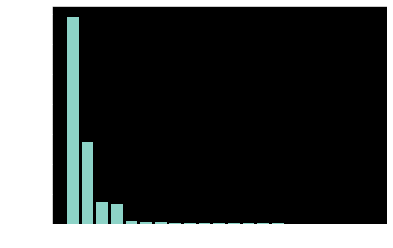

In [21]:
topPublishers = [(p, len(history.publisher[history.publisher == p])) for p in pubs]
topPublishers = sorted(topPublishers, key=lambda x: -x[1])
plt.bar(range(len(topPublishers)), [x[1] for x in topPublishers]);
topPublishers = [x[0] for x in topPublishers[:4]]
print(topPublishers)

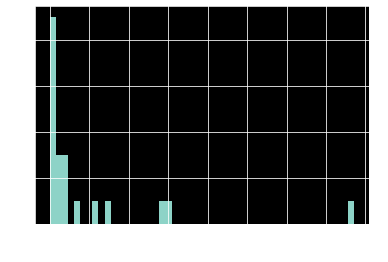

In [22]:
# Сколько уникальных пользователей на платформах?

history.groupby('publisher').user_id.apply(lambda users: len(set(users))).hist(bins=50)
plt.xlabel('Количество пользователей')
plt.ylabel('Количество платформ');

In [23]:
# Какой трафик на каждой платформе?

# Посчитаем для каждого часа: сколько постов было на каждой платформе?

n_publishers = len(history.publisher.unique())
posts_per_hour_by_publishers = []
TAKE_FIRST_N_HOURS = 24 * 4

for hour, hour_data in history[history.hour < TAKE_FIRST_N_HOURS].groupby('hour'):
    publishers_posts = hour_data.value_counts('publisher')
    
    counts = [0 for _ in range(n_publishers)]
    for pub_id, posts_n in list(publishers_posts.items()):
        counts[pub_id-1] = posts_n
        
    posts_per_hour_by_publishers.append([hour] + counts)

    
df = pd.DataFrame.from_records(posts_per_hour_by_publishers, columns=['hour'] + list(history.publisher.unique()))
df.head()

,hour,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,21,20
0,3,100,67,11,1,3,1,7,0,2,...,0,0,0,0,2,1,0,0,0,0
1,4,173,51,10,0,1,1,11,1,2,...,1,0,0,0,1,0,0,0,0,0
2,5,246,91,21,1,1,4,12,3,2,...,2,1,0,0,0,0,0,0,0,0
3,6,346,95,27,2,0,5,16,1,4,...,0,0,0,0,1,1,0,0,0,0
4,7,488,157,29,2,5,5,42,3,6,...,0,0,0,0,0,0,0,0,0,0


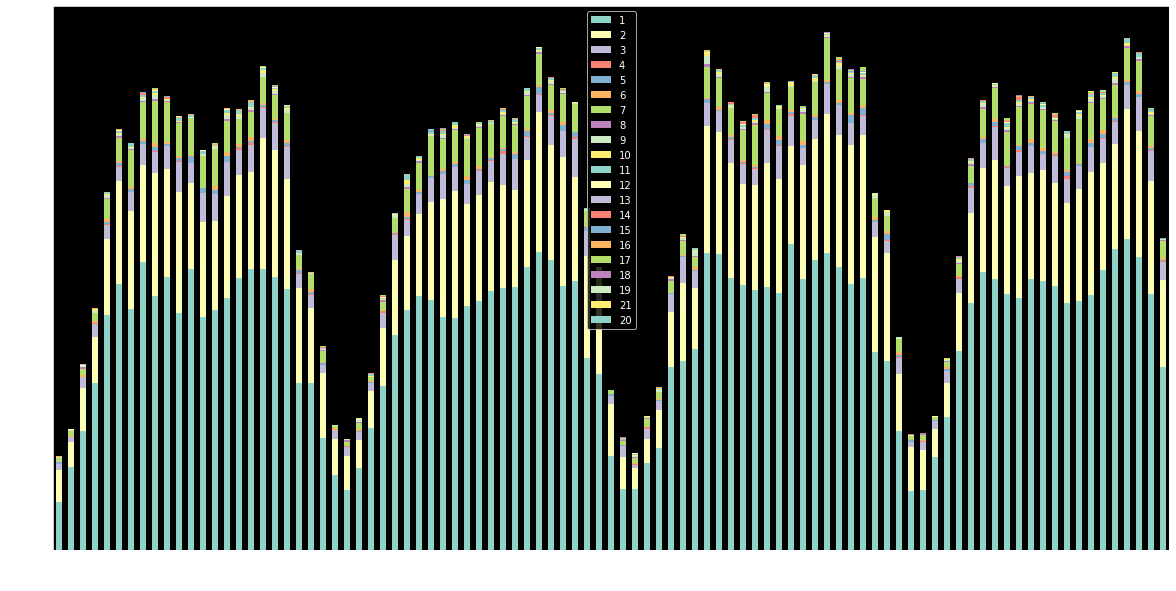

In [24]:
df.plot.bar(x='hour', stacked=True, figsize=(20, 10))
plt.xlabel('Час')
plt.ylabel('Количество постов');

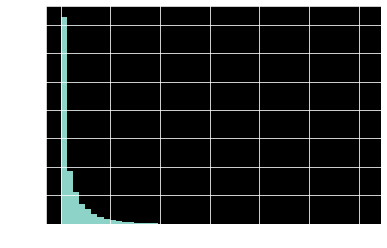

In [25]:
# И сколько постов посмотрел каждый пользователь?
vc = history.value_counts('user_id')
vc.hist(bins=50);

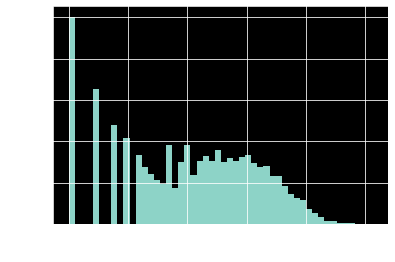

In [26]:
# Логарифмируем
np.log2(vc).hist(bins=50)
plt.xlabel('log2(просмотрено постов пользователем)')
plt.ylabel('Количество таких пользователей');

#### Об результате рекламных компаний

In [27]:
posts = pd.read_csv('data/raw/ads.csv')
posts.head(7)

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,ad_id
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",1
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",2
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",3
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",4
5,141.0,1288,1322,"3,8,11,15",856,"111,217,235,247,292,340,398,540,541,546,581,61...",5
6,250.0,1198,1451,"1,3,7,10,13,18",336,"24,43,96,124,150,256,299,313,430,450,552,557,5...",6


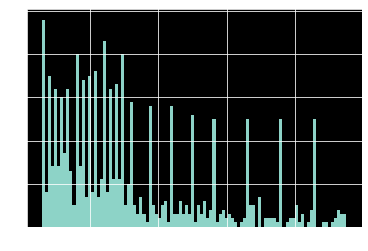

In [28]:
# Сколько по итогам аукциона стоит объявление
posts.cpm.hist(bins=100);

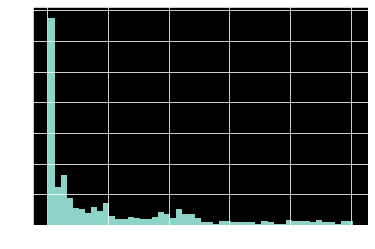

In [29]:
# Сколько часов длится рекламная компания

duration = (posts.hour_end - posts.hour_start)
duration.hist(bins=50);

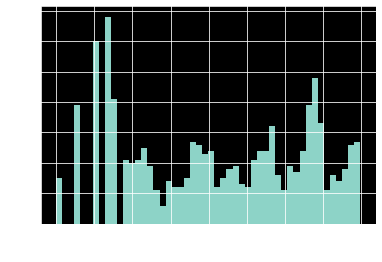

In [30]:
np.log2(duration).hist(bins=50)
plt.xlabel('log(длительность в часах)')
plt.ylabel('количество объявлений');

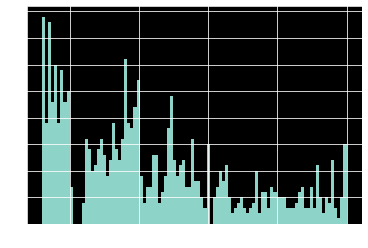

In [31]:
# На какую аудиторию крутилось объявление

posts.audience_size.hist(bins=100);

#### Об охвате

In [32]:
answers = pd.read_csv('data/raw/target.csv')
answers.head(7)

,ad_id,at_least_one
0,0,0.0430
1,1,0.0130
2,2,0.0878
3,3,0.2295
4,4,0.3963
5,5,0.0187
6,6,0.3839


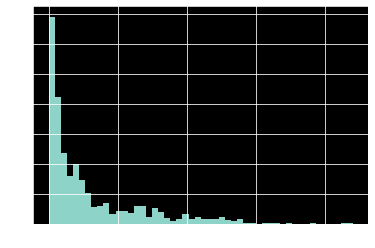

In [33]:
# Какая часть аудитории увидело объявление хоть раз
answers.at_least_one.hist(bins=50);

Если у вас нет непонимания и вопросов о данных, то вы посмотрели хороший анализ данных. Возможно выше неплохой анализ

### Построим модель

#### Выделим числовые признаки

In [34]:
import seaborn as sns

In [35]:
# Соберём простую информацию по каждому объявлению в датасет

# Добавим номер объявления
ads0 = pd.merge(posts, answers, on='ad_id', suffixes=('', None), how='outer')
ads0.drop('user_ids', axis='columns').head(3)

,cpm,hour_start,hour_end,publishers,audience_size,ad_id,at_least_one
0,220.0,1058,1153,"7,17",1906,0,0.0430
1,312.0,1295,1301,"3,18",1380,1,0.0130
2,70.0,1229,1249,"1,2,3,9,15,21",888,2,0.0878


In [36]:
def calcDaytime(s, e):
    s1 = s % 24
    e1 = e % 24
    dayS = bestHours[0]
    dayE = bestHours[-1]
    d = dayE - dayS
    return (e // 24 - s // 24 + 1) * d \
            - np.clip(s1 - dayS, 0, d) \
            - np.clip(dayE - e1, 0, d)

def calcBestPublisheres(s):
    res = 0
    for i in map(int, s.split(',')):
        if i in topPublishers:
            res += 1
    return res

assert calcDaytime(np.array([12]), np.array([14])) == [2]
assert calcDaytime(np.array([23]), np.array([4 + 24])) == [0]

mappedIds = ads0.user_ids.apply(lambda s: np.array(s.split(','), dtype=int))
ads0['usersLnk'] = mappedIds.apply(lambda s: users[users.user_id.isin(s)])
meanAge = users.age.mean()

ads = ads0.assign( n_publishers=ads0.publishers.apply(lambda s: len(s.split(',')))
                 , duration=ads0.hour_end - ads0.hour_start
                 , genderRatio=ads0.usersLnk.apply(lambda x: x.sex.mean() * 2 - 3).fillna(0)
                 , avgAge=ads0.usersLnk.apply(lambda x: x.age.mean()).fillna(meanAge)
                 , logAudience=np.log(ads0.audience_size)
                 , daytime=calcDaytime(ads0.hour_start, ads0.hour_end)
                 , logCpm=np.log(ads0.cpm)
                 , bestPublishers=ads0.publishers.apply(calcBestPublisheres)
                 )
ads = ads.assign( logDuration=np.log(ads.duration)
                )

def filterPd(p, *cols):
    for c in cols:
        try: p.drop(c, axis='columns', inplace=True)
        except: pass

filterPd( ads
        , 'hour_start'
        , 'hour_end'
        , 'user_ids'
        , 'ad_id_2'
        , 'publishers'
        , 'usersLnk'
        , 'id'
        )
ads.head(5)

,cpm,audience_size,ad_id,at_least_one,n_publishers,duration,genderRatio,avgAge,logAudience,daytime,logCpm,bestPublishers,logDuration
0,220.0,1906,0,0.0430,2,95,-0.081948,29.035530,7.552762,52,5.393628,1,4.553877
1,312.0,1380,1,0.0130,2,6,-0.062058,27.677141,7.229839,0,5.743003,1,1.791759
2,70.0,888,2,0.0878,6,20,-0.067164,29.748756,6.788972,13,4.248495,3,2.995732
3,240.0,440,3,0.2295,2,82,-0.075000,28.357500,6.086775,39,5.480639,1,4.406719
4,262.0,1476,4,0.3963,4,238,-0.224407,44.759322,7.297091,130,5.568345,3,5.472271


In [37]:
def heatmap(data: pd.DataFrame):
    plt.figure(figsize=(10, 9))
    sns.heatmap(data.corr(), square=True, linecolor='white', annot=True)
    plt.yticks(rotation=30)
    plt.xticks(rotation=30)
    plt.show()

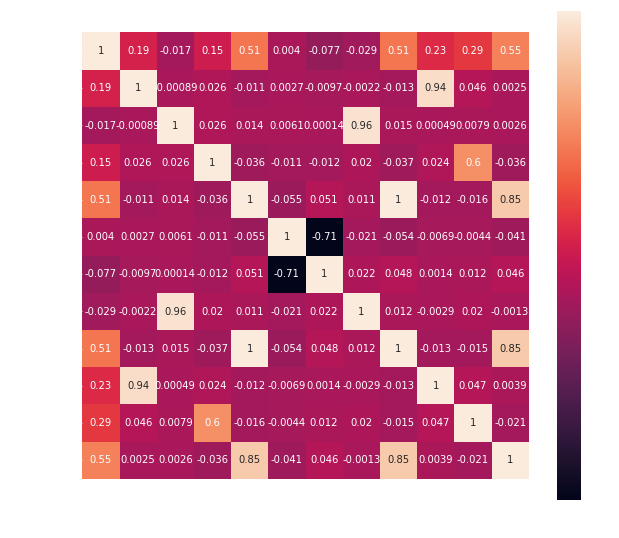

In [38]:
def move2Front(df, col0):
    return df[ [col0] + [col for col in df.columns if col != col0] ]
heatmap(move2Front(ads.drop('ad_id', axis='columns'), 'at_least_one'))

Разница полов не скореллировала, значит обе половины населения одинаково платежеспособны.
Интересно, что скореллировал возраст и разброс полов, возможно, это hot moms....

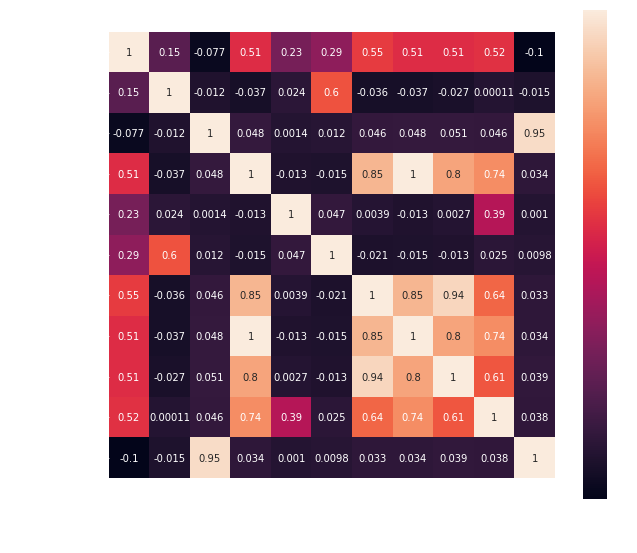

In [39]:
ads_featured = ads.assign( day_x_atanaudience=ads.daytime*np.arctan(ads.audience_size)
                         , log_dur_x_audience=np.log(ads.duration*ads.audience_size)
                         , cpm_x_duration=ads.cpm*ads.duration
                         , ageGender=ads.avgAge*(ads.genderRatio + 1.5)
                         )
filterPd( ads_featured
        , 'duration'
        , 'audience_size'
        , 'cpm'
        , 'genderRatio'
        , 'logAudience'
        )

heatmap(move2Front(ads_featured.drop('ad_id', axis='columns'), 'at_least_one'));

#### Обучим линейную регрессию

In [40]:
from typing import Tuple
from sklearn.model_selection import train_test_split

In [41]:
def make_xy(data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    x = data.drop('at_least_one', axis='columns').drop('ad_id', axis='columns')
    y = data['at_least_one']
    return x, y

In [42]:
def mape(pred: np.ndarray, trueth: np.ndarray) -> np.ndarray:
    # mean_absolute_percentage_error with clipping huge values
    err = np.array(abs(pred - trueth) / trueth)
    err[err > 20] = 20 # clip 2000% error
    return err

In [43]:
train, test = \
    train_test_split ( ads_featured[ads_featured.at_least_one.notna()]
                     , test_size=0.01
                     , random_state=30
                     )

### Насколько вообще разделимы данные?

In [44]:
import umap

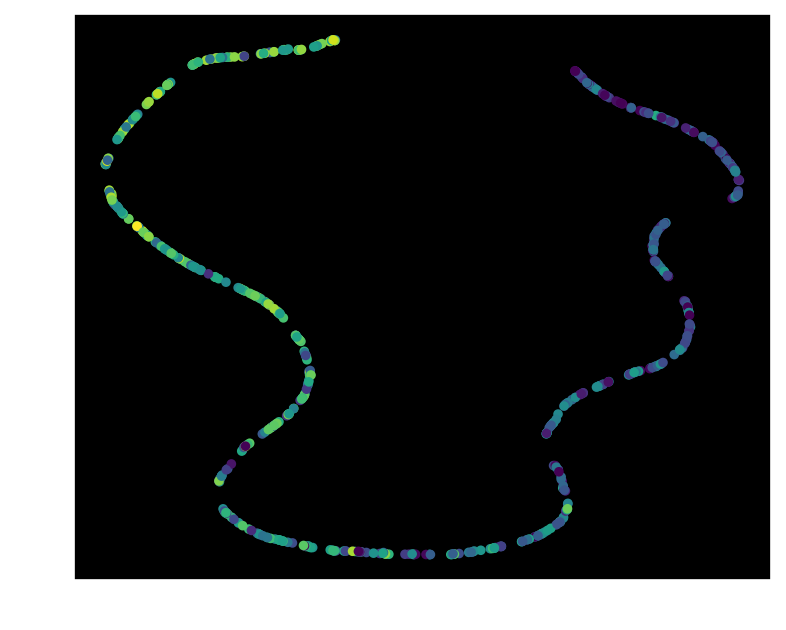

In [45]:
# Покажем похожие объявления точками, а охват цветом. Но на данных с доп фичами
ads_featured_umap = ads_featured.copy()
filterPd(ads_featured_umap, 'ad_id', 'at_least_one')
embedding = umap.UMAP().fit_transform(ads_featured_umap)
del ads_featured_umap

plt.figure(figsize=(6, 5), dpi=150)

color = np.log1p(ads.at_least_one * 100)
plt.scatter(embedding[:, 0], embedding[:, 1], s=13, c=color);

In [62]:
def checkModel(x, y, xtest, ytest, maker):
    mod = maker()
    mod.fit(x, np.log(y))
    errors = mape(np.exp(mod.predict(x)), y)
    plt.hist(errors, bins=100)
    plt.show()

    errors = mape(np.exp(mod.predict(xtest)), ytest)
    plt.hist(errors, bins=100)
    err = errors.mean()
    plt.show()
    print('Ошибка на test:', err)
    print('Ошибка на train:', errors.mean())
    return (err, mod)

In [63]:
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor

LinearRegression


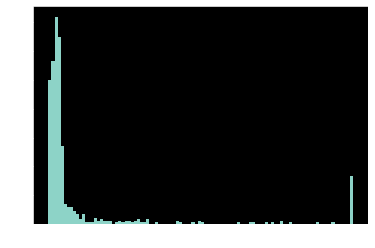

Ошибка на train: 2.0284401624477035
Ошибка на test: 1.7345994406898373


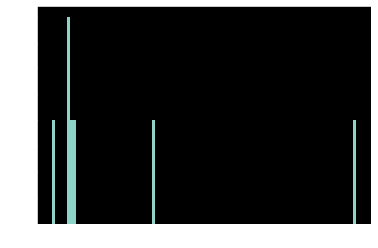

-------------
Least error 1.7345994406898373 on LinearRegression


In [66]:
x, y = make_xy(train)
xtest, ytest = make_xy(test)

gens = [LinearRegression] #, Ridge, Lasso, SGDRegressor, QuantileRegressor]
err = 10 ** 8
bestModelMaker = None
bestModel = None

for i in gens:
    print(type(i()).__name__)
    e, m = checkModel(x, y, xtest, ytest, i)
    print('-------------')
    if e < err:
        err = e
        bestModelMaker = i
        bestModel = m

print('Least error', e, 'on', type(bestModel).__name__)

In [67]:
res = pd.DataFrame()
predictPd = ads_featured[ads_featured.at_least_one.isna()].copy()
res['ad_id'] = predictPd.ad_id
filterPd ( predictPd
         , 'at_least_one'
         , 'ad_id'
         )
# predictPd.dropna(inplace=True)
# predictPd.reset_index(drop=True, inplace=True)
res['at_least_one'] = np.exp(bestModel.predict(predictPd))
res.to_csv('data/res.csv', columns=['ad_id', 'at_least_one'], index=False)
predictPd.dropna().head(5)
# res.head(5)

,n_publishers,avgAge,daytime,logCpm,bestPublishers,logDuration,day_x_atanaudience,log_dur_x_audience,cpm_x_duration,ageGender
700,4,28.383871,4,5.799093,2,1.609438,6.271557,7.450080,1650.0,42.758928
701,3,29.466251,79,4.369448,1,5.017280,124.052604,12.597980,11929.0,43.915243
702,3,29.104485,5,4.867534,1,1.609438,7.851898,9.392662,650.0,41.894042
703,5,29.101010,0,4.897840,2,1.098612,0.000000,8.679312,402.0,41.920479
704,4,32.964506,13,3.912023,2,3.401197,20.411249,10.665228,1500.0,44.054417
